In [123]:
import math
import torch
import numpy as np
import gpytorch
import pandas as pd
import seaborn as sns
import os
from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import KFold

%matplotlib inline
%load_ext autoreload
%autoreload 2

import imblearn
print("imblearn version: ",imblearn.__version__)
from imblearn.over_sampling import SMOTE

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import confusion_matrix
import itertools


from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
imblearn version:  0.12.0


In [5]:
# from sklearn 0.19.2 documentation:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar(shrink=0.7)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [125]:
def plot_tsne(input, y_true, n_components): 
    tsne = TSNE(n_components=n_components, random_state=42)
    embedded_data = tsne.fit_transform(input)
    plt.figure(figsize=(8, 6))
    plt.scatter(embedded_data[:, 0], embedded_data[:, 1], c=y_true, cmap='viridis')
    plt.title('t-SNE Visualization')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.colorbar(label='Labels')
    plt.show();

In [36]:
def look_at_data(filepath):
    """5-fold on majority and minority separately, then concat into one df""" 
    df = pd.read_csv(filepath)

    print("Dataset shape:",df.shape)
    print(df.active.value_counts())

    num_gap = (df.loc[df['active']==0].shape[0]) - (df.loc[df['active']==1].shape[0])
    print("\nDifference in class sample sizes: ",num_gap)

    num_minority = df.loc[df['active']==1].shape[0]
    print("Number of minority samples: ",num_minority)
    print(df.describe())
    print(f"active/inactive: {df['active'].value_counts()}")
    print(f"active/inactive: {df['active'].value_counts()}")
    counts_per_fold = df.groupby('fold')['active'].value_counts()
    print(counts_per_fold)
    return df

In [37]:
split_path = '../../../data/NEK_data_4Berkeley/NEK2/'
file = 'NEK2_1_uM_min_50_pct_binding_5fold_random_imbalanced.csv'
all_fold_df = look_at_data(split_path+'NEK2_1_uM_min_50_pct_binding_5fold_random_imbalanced.csv')

Dataset shape: (1408, 310)
active
0    1351
1      57
Name: count, dtype: int64

Difference in class sample sizes:  1294
Number of minority samples:  57
            active  ASA+_per_atom         ASA-  ASA_H_per_atom        ASA_P  \
count  1408.000000    1408.000000  1408.000000     1408.000000  1408.000000   
mean      0.040483       7.926911   230.466349        9.285040   169.369637   
std       0.197159       1.129878    61.514603        1.569927    58.860756   
min       0.000000       3.080406    52.667549        4.012970    28.871466   
25%       0.000000       7.202915   188.174525        8.149767   127.916335   
50%       0.000000       7.894244   225.744500        9.243976   164.295715   
75%       0.000000       8.663926   267.609922       10.296403   204.593105   
max       1.000000      14.897949   641.862060       15.058283   560.555180   

       ASA_per_atom  BCUT_PEOE_0  BCUT_PEOE_1  BCUT_PEOE_2  BCUT_PEOE_3  ...  \
count   1408.000000  1408.000000  1408.000000  1408.000

In [38]:
# train fold 1
split_path = "../../../data/datasets/NEK_data_4Berkeley/NEK2"
# /Users/jayceepang/msse/capstone/data/NEK_data_4Berkeley/NEK2/NEK2_binding_random_fold1_testY.csv
train_x_df_temp = pd.read_csv(split_path+"/NEK2_binding_random_fold1_trainX.csv")
train_y_df_temp = pd.read_csv(split_path+"/NEK2_binding_random_fold1_trainY.csv")
test_x_df = pd.read_csv(split_path+"/NEK2_binding_random_fold1_testX.csv")
test_y_df = pd.read_csv(split_path+"/NEK2_binding_random_fold1_testY.csv")

In [39]:
test_y_df.shape
train_x_df_temp.shape
train_y_df_temp.shape
test_x_df.shape

(283, 306)

In [42]:
# SMOTE: Adjust imbalanced training data

# transform the dataset
oversample = SMOTE()
new_train_x_df, new_train_y_df = oversample.fit_resample(train_x_df_temp, train_y_df_temp)

display(new_train_x_df.head)

display("original training size: ",train_x_df_temp.shape)
# display(train_y_df_temp.value_counts())
display("SMOTE train set size:",new_train_x_df.shape)
# display(new_train_y_df.value_counts())

<bound method NDFrame.head of       ASA+_per_atom        ASA-  ASA_H_per_atom       ASA_P  ASA_per_atom  \
0         14.897949   53.326256        8.903966  161.217960     17.860519   
1          8.496225  275.100830        8.517174  278.048280     13.229856   
2          6.791036  344.713500        8.136228  261.311580     12.350931   
3          7.619170  252.392720        8.119836  235.214870     13.346833   
4          9.629118  190.869540       11.334554  127.854520     14.530917   
...             ...         ...             ...         ...           ...   
2155       7.333085  130.358229        6.188742  230.329509      8.889200   
2156       7.330988  299.834207        9.053096  174.343035     11.452442   
2157       7.182516  358.323326        8.926293  249.238643     12.701460   
2158       6.049819  319.708026        8.455105  139.208187     10.392955   
2159       8.161490  178.350116        8.901015  140.208829     11.170217   

      BCUT_PEOE_0  BCUT_PEOE_1  BCUT_PEOE_2  

'original training size: '

(1125, 306)

'SMOTE train set size:'

(2160, 306)

In [31]:
# save to files 
train_x_df = new_train_x_df
train_y_df = new_train_y_df

train_x_df.to_csv(split_path+"/NEK2_1_uM_min_50_pct_binding_random_smote_fold1_trainX.csv", index=False)
train_y_df.to_csv(split_path+"/NEK2_1_uM_min_50_pct_binding_random_smote_fold1_trainY.csv", index=False)
test_x_df.to_csv(split_path+"/NEK2_1_uM_min_50_pct_binding_random_smote_fold1_testX.csv", index=False)
test_y_df.to_csv(split_path+"/NEK2_1_uM_min_50_pct_binding_random_smote_fold1_testY.csv", index=False)


In [45]:
indices = test_y_df.index[test_y_df['active'] == 1]
indices

Index([271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282], dtype='int64')

In [109]:
# Transform data to PyTorch tensors

# Scale data
x_df = pd.concat([train_x_df, test_x_df])

scaling=StandardScaler()
 
# Use fit and transform method 
scaling.fit(x_df)
Scaled_data=scaling.transform(x_df)
train_scaled_data = scaling.transform(train_x_df)
test_scaled_data = scaling.transform(test_x_df) 


train_x_temp = train_scaled_data.astype("long")
test_x_temp = test_scaled_data.astype("long")

train_y_temp = train_y_df.to_numpy().flatten().astype("long")
test_y_temp = test_y_df.to_numpy().flatten().astype("long")


train_x = torch.from_numpy(train_x_temp)
train_y = torch.from_numpy(train_y_temp)
test_x = torch.from_numpy(test_x_temp)
test_y = torch.from_numpy(test_y_temp)


print(train_x.shape)
print(train_y.shape)

torch.Size([2160, 306])
torch.Size([2160])


In [114]:
# Construct a GP classification model

from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel

# We will use the simplest form of GP model, exact inference
class DirichletGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)




In [115]:
class Trainer: 
    def __init__(self,model, likelihood, iterations): 
        self.model = model
        self.likelihood = likelihood 

        smoke_test = ('CI' in os.environ)
        self.n_iterations = 2 if smoke_test else iterations
        # self.n_iterations = n_iterations 
        self.optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
        # loss function 
        self.loss_fn = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihood, self.model)
    def train(self, train_x, train_y): 
        self.model.train()
        self.likelihood.train()
        predictions = [] 
        for i in range(self.n_iterations): 
            self.optimizer.zero_grad()
            output = self.model(train_x)
            loss = -self.loss_fn(output, self.likelihood.transformed_targets).sum()
            loss.backward()
            if (i%10==0): 
                print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
                    i + 1, self.n_iterations, loss.item(),
                    self.model.covar_module.base_kernel.lengthscale.mean().item(),
                    self.model.likelihood.second_noise_covar.noise.mean().item()
                ))
             
          
            self.optimizer.step() 

            

    def predict(self, input): 
        # predict on validation set? 
        self.model.eval()
        self.likelihood.eval()

        with gpytorch.settings.fast_pred_var(), torch.no_grad():
            dist = self.model(input)     # get predicted distributions 
            pred_means = dist.loc          # extract means for each input 
            # pred_probs = self.likelihood(dist).probs #predicted probabilities 
            # f_mean = dist.mean
            # f_var = dist.variance
            # f_covar = dist.covariance_matrix
            # f_samples = dist.sample(sample_shape=torch.Size(1000))    
            observed_pred = self.likelihood(self.model(input))    # likelihood observed predictions 
            # f_preds = self.model(input)
            print(f'prediction means shape: {pred_means.numpy().shape}')
            print(f'class predictions: {pred_means.max(0)[1]}')
            # class_pred = pred_means.max(0)[1]
            class_pred = self.model(input).loc.max(0)[1].numpy()

        return observed_pred, pred_means,class_pred
    

    def evaluate(self, x_input, y_true, class_names, plot_name): 
        y_pred = self.model(x_input).loc.max(0)[1].numpy() 

        cm = confusion_matrix(y_true, y_pred)
        plt.rcParams.update({"font.size": 20})
        label_font = {'size':'18'}  # Adjust to fit
        ax = plt.figure(figsize=(5,5))
        plt.title(plot_name,fontsize=20)
        plot_confusion_matrix(cm, classes=class_names, normalize=False)
        plt.xlabel("Predicted",fontdict=label_font);
        plt.ylabel("Actual",fontdict=label_font);
        return y_pred
    
    
    def get_metrics(self, x, y_true, y_pred): 
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        dist = self.model(x)     # get predicted distributions 
        pred_means = dist.loc          # extract means for each input 
            # pred_probs = self.likelihood(dist).probs #predicted probabilities 
        # f_mean = dist.mean
        # f_var = dist.variance
        # f_covar = dist.covariance_matrix
        # f_samples = dist.sample(sample_shape=torch.Size(1000))    
        # recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        
        # # roc_auc = roc_auc_score(y_true, y_pred_proba) 
        # # fpr, tpr, thresholds_roc = roc_curve(y_true, y_pred_proba)
        # # roc_auc_curve = auc(fpr, tpr)
        # # precision, recall, thresholds_pr = precision_recall_curve(y_true, y_pred_proba)
        # # pr_auc_curve = auc(recall, precision)
        
        
        return accuracy, precision, f1
            

In [116]:
likelihood1 = DirichletClassificationLikelihood(train_y, learn_additional_noise=True)
model1 = DirichletGPModel(train_x, likelihood1.transformed_targets, likelihood1, num_classes=likelihood1.num_classes)
n_iterations = 300
trainer1 = Trainer(model1, likelihood1, n_iterations)
trainer1.train(train_x, train_y) 

Iter 1/300 - Loss: 7.037   lengthscale: 0.693   noise: 0.693
Iter 11/300 - Loss: 5.755   lengthscale: 1.320   noise: 1.288
Iter 21/300 - Loss: 5.018   lengthscale: 2.201   noise: 1.824
Iter 31/300 - Loss: 4.603   lengthscale: 3.265   noise: 1.894
Iter 41/300 - Loss: 4.271   lengthscale: 4.314   noise: 1.490
Iter 51/300 - Loss: 3.975   lengthscale: 5.262   noise: 0.878
Iter 61/300 - Loss: 3.760   lengthscale: 6.024   noise: 0.399
Iter 71/300 - Loss: 3.624   lengthscale: 6.575   noise: 0.171
Iter 81/300 - Loss: 3.566   lengthscale: 6.954   noise: 0.088
Iter 91/300 - Loss: 3.547   lengthscale: 7.208   noise: 0.056
Iter 101/300 - Loss: 3.530   lengthscale: 7.366   noise: 0.041
Iter 111/300 - Loss: 3.523   lengthscale: 7.466   noise: 0.032
Iter 121/300 - Loss: 3.513   lengthscale: 7.530   noise: 0.027
Iter 131/300 - Loss: 3.507   lengthscale: 7.574   noise: 0.023
Iter 141/300 - Loss: 3.508   lengthscale: 7.603   noise: 0.020
Iter 151/300 - Loss: 3.510   lengthscale: 7.627   noise: 0.018
Ite

In [126]:
train_x.shape

torch.Size([2160, 306])

/Users/jayceepang/msse/capstone/gpytorch-venv/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/Users/jayceepang/msse/capstone/gpytorch-venv/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


prediction means shape: (2, 2160)
class predictions: tensor([0, 0, 0,  ..., 1, 1, 1])
train predictions: [0 0 0 ... 1 1 1]
observed pred predictions: tensor([0, 0, 0,  ..., 1, 1, 1])


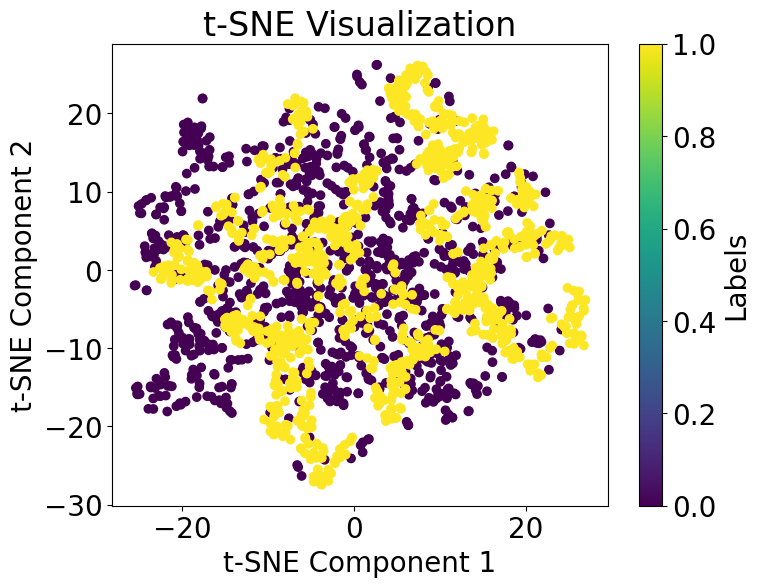

In [128]:
train_observed_pred, train_pred_means, train_pred  = trainer1.predict(train_x)
# print(f'pred means shape: {train_pred_means.numpy().shape}')
print(f'train predictions: {train_pred}')
print(f'observed pred predictions: {train_observed_pred.loc.max(0)[1]}')
trainer1.get_metrics(train_x, train_y, train_pred)
plot_tsne(train_x, train_y, 3)

Confusion matrix, without normalization
[[1079    1]
 [   0 1080]]


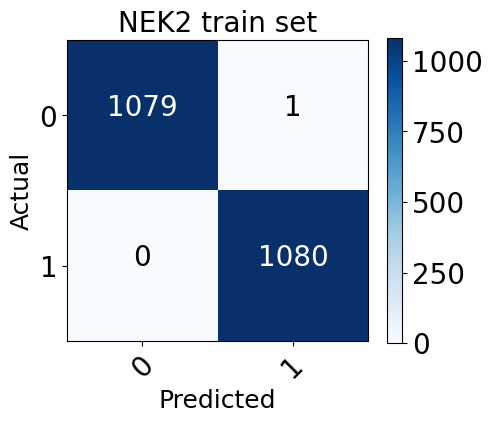

In [118]:
train_y_true = train_y_df.values
train_y_pred = train_pred
train_cm = confusion_matrix(train_y_true, train_y_pred)
class_names = ["0","1"]
plt.rcParams.update({"font.size": 20})
label_font = {'size':'18'}  # Adjust to fit
ax = plt.figure(figsize=(5,5))
plt.title("NEK2 train set",fontsize=20)
plot_confusion_matrix(train_cm, classes=class_names, normalize=False)
plt.xlabel("Predicted",fontdict=label_font);
plt.ylabel("Actual",fontdict=label_font);


In [119]:
# Make predictions 
test_observed_pred, test_pred_means, test_pred  = trainer1.predict(test_x)


prediction means shape: (2, 283)
class predictions: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1])


(0.9646643109540636, 0.6666666666666666, 0.4444444444444444)

slightly different output than Yaru's tutorial

In [88]:
indices = np.where(test_pred == 1)[0]
# indices # array([136, 146, 273, 276, 282]) compared to: 
# tutorial: array([125, 136, 146, 273, 276, 282]) 

Confusion matrix, without normalization
[[269   2]
 [  8   4]]


(0.9646643109540636, 0.6666666666666666, 0.4444444444444444)

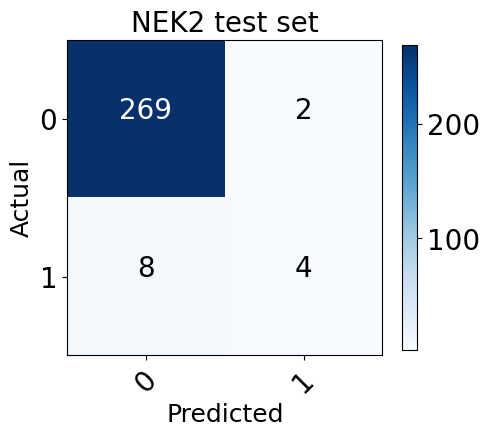

In [120]:
test_y_true = test_y_df.values.flatten()
test_y_pred = test_pred
test_cm = confusion_matrix(test_y_true, test_y_pred)
class_names = ["0","1"]

plt.rcParams.update({"font.size": 20})
label_font = {'size':'18'}  # Adjust to fit
ax = plt.figure(figsize=(5,5))
plt.title("NEK2 test set",fontsize=20)
plot_confusion_matrix(test_cm, classes=class_names, normalize=False)
plt.xlabel("Predicted",fontdict=label_font);
plt.ylabel("Actual",fontdict=label_font);
trainer1.get_metrics(test_x, test_y, test_pred)

In [94]:
test_observed_pred.mean.numpy() # test_pred.mean.numpy()  observed_pred = self.likelihood(self.model(input)) 
# pred_means = dist.loc
test_pred_variance2D = test_observed_pred.variance.numpy()
print(test_observed_pred.variance.numpy().shape)
test_pred_variance2D

(2, 283)


array([[1.5952085 , 1.8606242 , 1.8400629 , 1.8426859 , 1.7078159 ,
        1.7477549 , 1.8817252 , 1.3299022 , 1.6232935 , 1.8689835 ,
        1.8406597 , 1.7790496 , 1.8834368 , 1.7856345 , 1.4122326 ,
        1.8858424 , 1.683738  , 1.736842  , 1.6702073 , 1.5158557 ,
        1.8811555 , 1.7956803 , 1.3578293 , 1.7413166 , 1.806948  ,
        1.4770709 , 1.5423172 , 1.8740951 , 1.2722998 , 1.2563171 ,
        1.2970928 , 1.685582  , 1.8381776 , 1.8291465 , 1.7817773 ,
        1.8512263 , 1.6940256 , 1.8816459 , 1.7898548 , 1.3397754 ,
        1.5195798 , 1.8725045 , 1.8339871 , 1.8811383 , 1.7931021 ,
        1.7667801 , 1.4563128 , 1.8245164 , 1.6931661 , 1.8658801 ,
        1.7164322 , 1.7892196 , 1.8462157 , 1.685092  , 1.8510538 ,
        1.8861928 , 1.831164  , 1.1248046 , 1.7132195 , 1.7208564 ,
        1.7222044 , 1.8809427 , 1.7864069 , 1.750883  , 1.3028725 ,
        1.7043597 , 1.8752632 , 1.8445666 , 1.8526577 , 1.6974102 ,
        1.7081794 , 1.8843323 , 1.6053675 , 1.86

In [95]:
var_min = test_pred_variance2D.min(axis=0).min()
var_max = test_pred_variance2D.max(axis=0).max()
print(var_min, var_max)

0.97785723 3.0518148


In [96]:
# Training set variance
print(train_observed_pred.variance.numpy().shape)
train_observed_pred.variance.numpy()

(2, 2160)


array([[2.5722613, 2.3856013, 2.5220766, ..., 5.370945 , 5.2836704,
        5.1819763],
       [7.657178 , 6.6356673, 7.0869627, ..., 1.3787539, 1.2989876,
        1.2005723]], dtype=float32)

In [99]:
test_pred_variance = [test_pred_variance2D[value][idx] for idx,value in enumerate(test_pred)]
test_pred_variance

[1.5952085,
 1.8606242,
 1.8400629,
 1.8426859,
 1.7078159,
 1.7477549,
 1.8817252,
 1.3299022,
 1.6232935,
 1.8689835,
 1.8406597,
 1.7790496,
 1.8834368,
 1.7856345,
 1.4122326,
 1.8858424,
 1.683738,
 1.736842,
 1.6702073,
 1.5158557,
 1.8811555,
 1.7956803,
 1.3578293,
 1.7413166,
 1.806948,
 1.4770709,
 1.5423172,
 1.8740951,
 1.2722998,
 1.2563171,
 1.2970928,
 1.685582,
 1.8381776,
 1.8291465,
 1.7817773,
 1.8512263,
 1.6940256,
 1.8816459,
 1.7898548,
 1.3397754,
 1.5195798,
 1.8725045,
 1.8339871,
 1.8811383,
 1.7931021,
 1.7667801,
 1.4563128,
 1.8245164,
 1.6931661,
 1.8658801,
 1.7164322,
 1.7892196,
 1.8462157,
 1.685092,
 1.8510538,
 1.8861928,
 1.831164,
 1.1248046,
 1.7132195,
 1.7208564,
 1.7222044,
 1.8809427,
 1.7864069,
 1.750883,
 1.3028725,
 1.7043597,
 1.8752632,
 1.8445666,
 1.8526577,
 1.6974102,
 1.7081794,
 1.8843323,
 1.6053675,
 1.8614624,
 1.541882,
 1.7392758,
 1.6768606,
 1.8862181,
 1.8150523,
 1.8490981,
 1.5860037,
 1.865018,
 1.8490599,
 1.3631032,
 

In [100]:
display(np.arange(len(test_y_true)).shape)
display((test_y_true - test_pred).shape)
display(test_y_true.shape)
display(test_pred.shape)

(283,)

(283,)

(283,)

(283,)

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_65491/3516929116.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu').reversed()


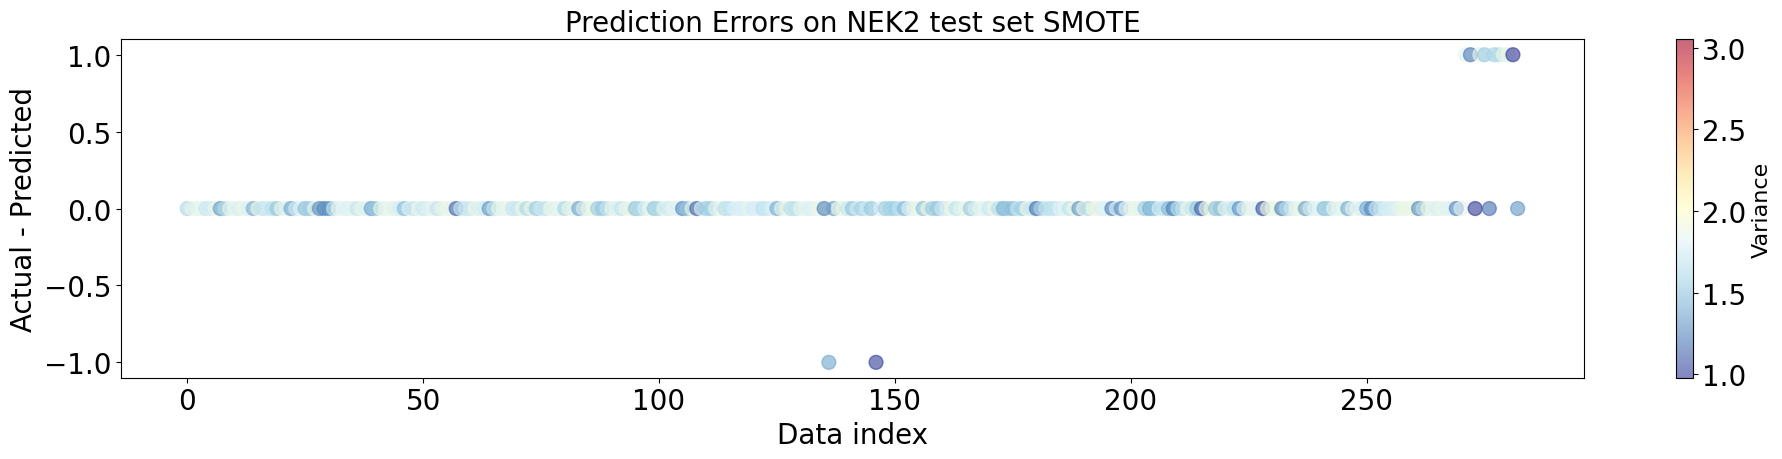

In [101]:
plt.rcParams.update({"font.size": 20})

marker = ['s', 'o', 'D', 'v']
cm = plt.cm.get_cmap('RdYlBu').reversed() 

fig = plt.figure(figsize=(20,5))

plt.title("Prediction Errors on NEK2 test set SMOTE",fontsize=20)

#plt.plot(y_true, marker=marker[0],markerfacecolor='None',linestyle='None',label="Actual")
#plt.plot(test_prob[1], marker=marker[1],markerfacecolor='None',linestyle='None',label="Predicted")

sc=plt.scatter(np.arange(len(test_y_true)),(test_y_true - test_pred), c=test_pred_variance, s=100, cmap=cm, alpha=0.6,vmin=var_min, vmax=var_max)
#plt.colorbar(sc)

clb=plt.colorbar()
clb.set_label('Variance',fontsize=16)

plt.xlabel('Data index')
plt.ylabel('Actual - Predicted')
#plt.plot(test_prob[0], marker=marker[2],markerfacecolor='None',linestyle='None',label="Probability")
#plt.legend(fontsize=10)
fig.tight_layout()

plt.show()

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_65491/223658704.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu').reversed()


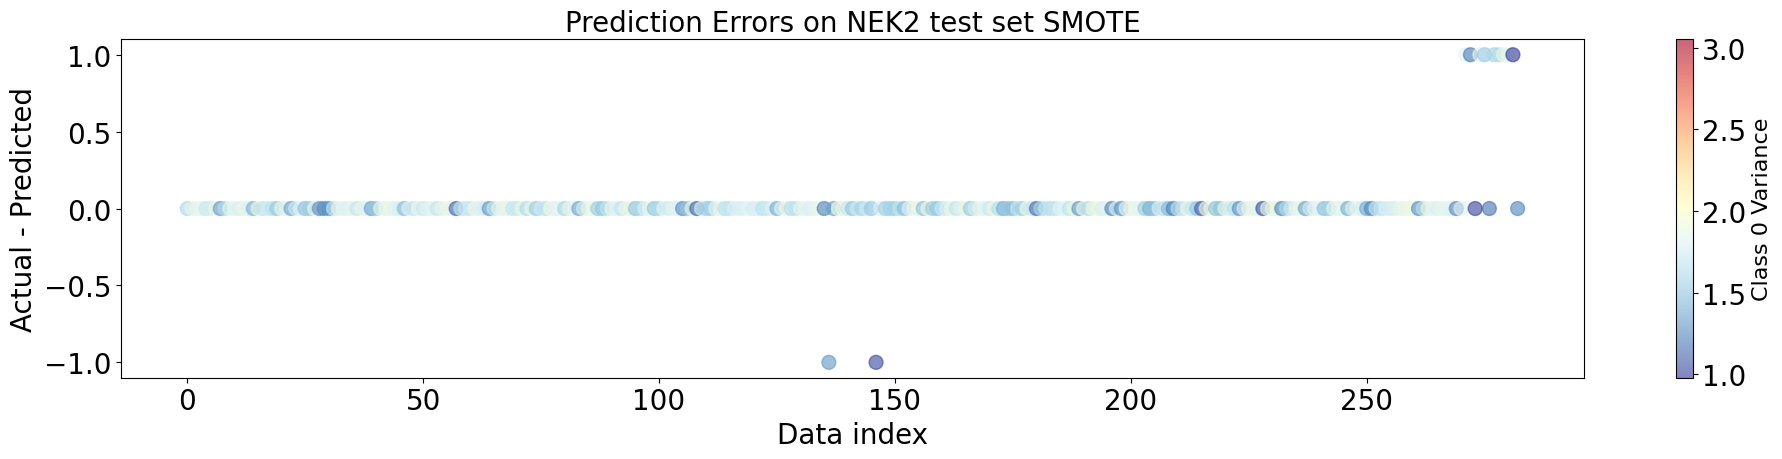

In [102]:
plt.rcParams.update({"font.size": 20})

marker = ['s', 'o', 'D', 'v']
cm = plt.cm.get_cmap('RdYlBu').reversed() 

fig = plt.figure(figsize=(20,5))

plt.title("Prediction Errors on NEK2 test set SMOTE",fontsize=20)

#plt.plot(y_true, marker=marker[0],markerfacecolor='None',linestyle='None',label="Actual")
#plt.plot(test_prob[1], marker=marker[1],markerfacecolor='None',linestyle='None',label="Predicted")

sc=plt.scatter(np.arange(len(test_y_true)),(test_y_true - test_pred), c=test_pred_variance2D[0], s=100, cmap=cm, alpha=0.6,vmin=var_min, vmax=var_max)
#plt.colorbar(sc)

clb=plt.colorbar()
clb.set_label('Class 0 Variance',fontsize=16)

plt.xlabel('Data index')
plt.ylabel('Actual - Predicted')
#plt.plot(test_prob[0], marker=marker[2],markerfacecolor='None',linestyle='None',label="Probability")
#plt.legend(fontsize=10)
fig.tight_layout()

plt.show()

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_65491/1985153713.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu').reversed()


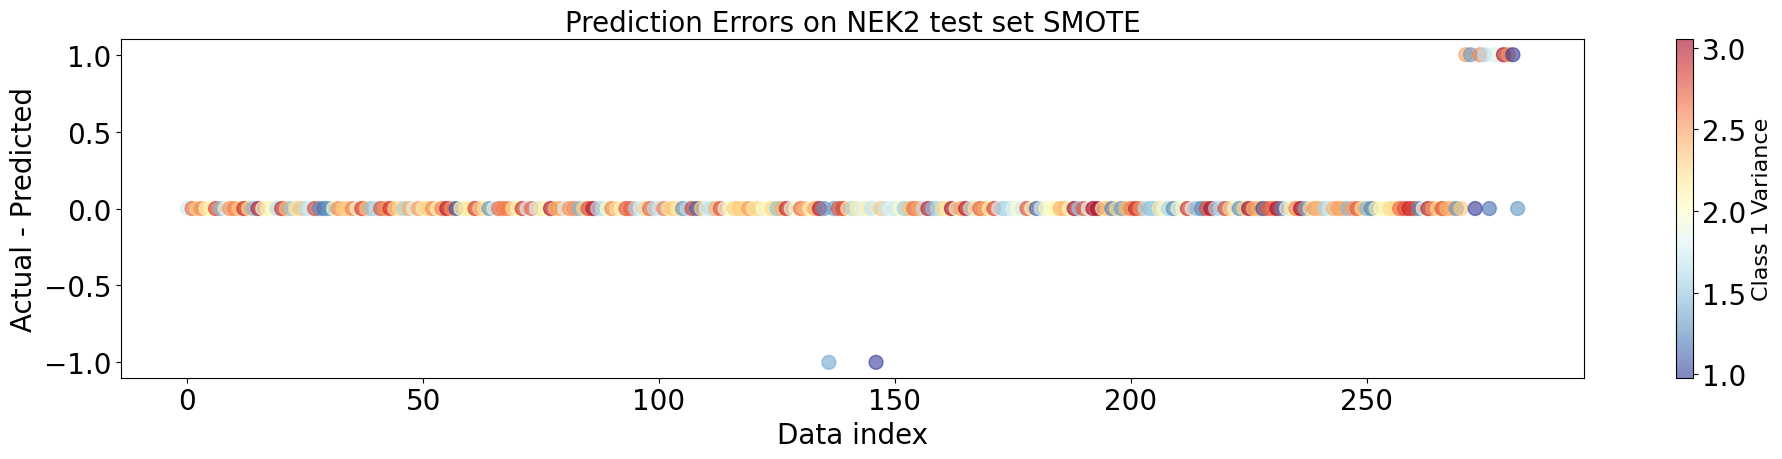

In [103]:
plt.rcParams.update({"font.size": 20})

marker = ['s', 'o', 'D', 'v']
cm = plt.cm.get_cmap('RdYlBu').reversed() 

fig = plt.figure(figsize=(20,5))

plt.title("Prediction Errors on NEK2 test set SMOTE",fontsize=20)

#plt.plot(y_true, marker=marker[0],markerfacecolor='None',linestyle='None',label="Actual")
#plt.plot(test_prob[1], marker=marker[1],markerfacecolor='None',linestyle='None',label="Predicted")

sc=plt.scatter(np.arange(len(test_y_true)),(test_y_true - test_pred), c=test_pred_variance2D[1], s=100, cmap=cm, alpha=0.6,vmin=var_min, vmax=var_max)
#plt.colorbar(sc)

clb=plt.colorbar()
clb.set_label('Class 1 Variance',fontsize=16)

plt.xlabel('Data index')
plt.ylabel('Actual - Predicted')
#plt.plot(test_prob[0], marker=marker[2],markerfacecolor='None',linestyle='None',label="Probability")
#plt.legend(fontsize=10)
fig.tight_layout()

plt.show()